In [542]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyflux as pf

from functools import reduce
import itertools
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, log_loss

sns.set_style('whitegrid')
%matplotlib inline

* Date – Date and time of the bid
* Hour – Hour of the bid
* ExternalId – campaign
* Domain – domain
* PlacementId – placement
* Placements – number of buying Placements
* Impressions – number of selling Impressions
* FillRate = Impressions/ Placements
* BuyCpm – price that we buy Placements
* SellCpm – price that we sell Impressions
* ApbCpm – price that we setup to buy Impressions
* Margin – Margin in USD
* MarginPercent – MarginPercent in %

Objective: To construct an algorithm that will calculate ApbCpm to maximize Margin.

In [2]:
df = pd.read_csv('TestData.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 13 columns):
Date             2000 non-null object
Hour             2000 non-null int64
ExternalId       2000 non-null object
Domain           2000 non-null object
PlacementId      2000 non-null int64
Placements       2000 non-null int64
Impressions      2000 non-null int64
FillRate         2000 non-null float64
BuyCpm           2000 non-null float64
SellCpm          2000 non-null float64
ApbCpm           2000 non-null float64
Margin           2000 non-null float64
MarginPercent    2000 non-null float64
dtypes: float64(6), int64(4), object(3)
memory usage: 203.2+ KB


In [3]:
domains = list(df['Domain'].unique())

In [4]:
df.head()

,Date,Hour,ExternalId,Domain,PlacementId,Placements,Impressions,FillRate,BuyCpm,SellCpm,ApbCpm,Margin,MarginPercent
0,2016-08-01 04:00:00,4,BC-US-8|13807760,myfox8.com,5410238,2,0,0.0,4.502,2.754,0.001,-0.009,0.0
1,2016-07-31 23:00:00,23,BC-US-8|13807760,hotnewhiphop.com,506724,0,1,0.0,0.000,2.871,0.001,0.000,0.0
2,2016-07-31 23:00:00,23,BC-US-8|13807760,drudgereport.com,6340489,1,0,0.0,1.320,3.366,0.001,-0.001,0.0
3,2016-07-31 16:00:00,16,BC-US-8|13807760,bloodyelbow.com,3640217,0,1,0.0,0.000,4.842,0.001,0.000,0.0
4,2016-07-31 02:00:00,2,BC-US-14|13859978,zillow.com,6397031,3,0,0.0,1.200,1.863,2.012,-0.004,0.0


### Hours distribution

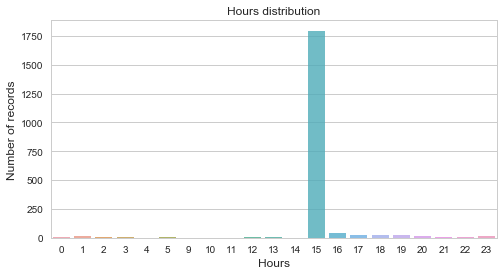

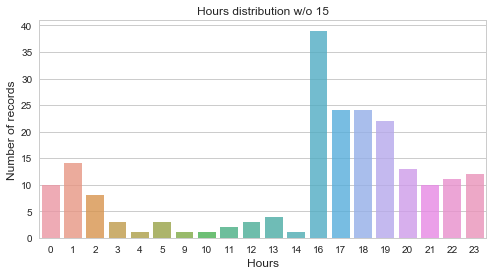

In [5]:
cnt_hours = df['Hour'].value_counts()
cnt_hours15 = df[df['Hour'] != 15]['Hour'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(cnt_hours.index, cnt_hours.values, alpha=0.8)
plt.ylabel('Number of records', fontsize=12)
plt.xlabel('Hours', fontsize=12)
plt.title('Hours distribution')

plt.figure(figsize=(8,4))
sns.barplot(cnt_hours15.index, cnt_hours15.values, alpha=0.8)
plt.ylabel('Number of records', fontsize=12)
plt.xlabel('Hours', fontsize=12)
plt.title('Hours distribution w/o 15')
plt.show()

In [6]:
df1 = df[df['MarginPercent'] > 0]

C:\Users\dmytro.sakovych\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


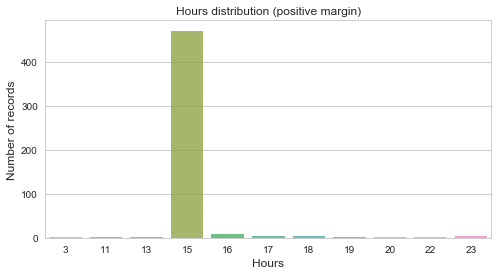

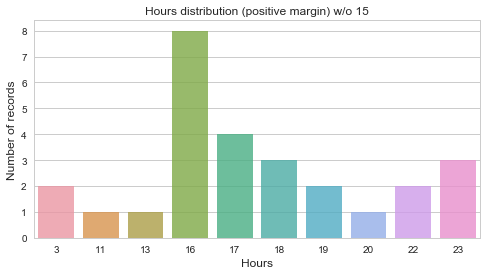

In [7]:
cnt_hours = df1['Hour'].value_counts()
cnt_hours15 = df1[df['Hour'] != 15]['Hour'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(cnt_hours.index, cnt_hours.values, alpha=0.8)
plt.ylabel('Number of records', fontsize=12)
plt.xlabel('Hours', fontsize=12)
plt.title("Hours distribution (positive margin)")

plt.figure(figsize=(8,4))
sns.barplot(cnt_hours15.index, cnt_hours15.values, alpha=0.8)
plt.ylabel('Number of records', fontsize=12)
plt.xlabel('Hours', fontsize=12)
plt.title('Hours distribution (positive margin) w/o 15')
plt.show()

### Number of positive margin records:

In [8]:
len(df[df['MarginPercent'] > 0]) / len(df)

0.249

### Total margin by hour

In [9]:
hours = list(df['Hour'].unique())

data = []
data15 = []
for hour in hours:
    data15.append((hour, df[df['Hour'] == hour]['Margin'].sum()))
    if hour == 15:
        continue
    data.append((hour, df[df['Hour'] == hour]['Margin'].sum()))

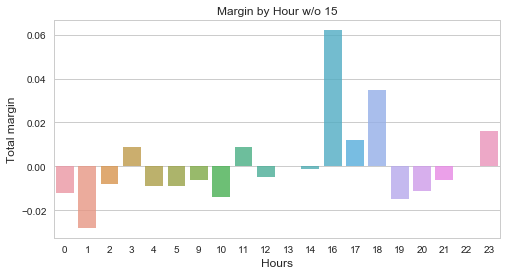

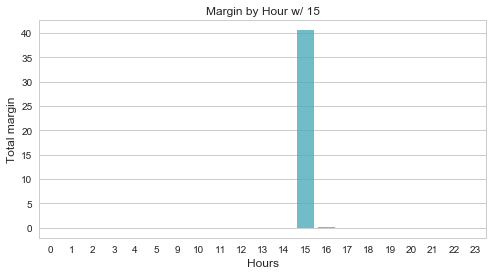

In [10]:
plt.figure(figsize=(8,4))
sns.barplot(list(map(lambda x: x[0], data)), list(map(lambda x: x[1], data)), alpha=0.8)
plt.ylabel('Total margin', fontsize=12)
plt.xlabel('Hours', fontsize=12)
plt.title('Margin by Hour w/o 15')

plt.figure(figsize=(8,4))
sns.barplot(list(map(lambda x: x[0], data15)), list(map(lambda x: x[1], data15)), alpha=0.8)
plt.ylabel('Total margin', fontsize=12)
plt.xlabel('Hours', fontsize=12)
plt.title('Margin by Hour w/ 15')
plt.show()

### High margin hours

In [11]:
hours = list(df1['Hour'].unique())

data = []
data15 = []
for hour in hours:
    data15.append((hour, df1[df1['Hour'] == hour]['Margin'].mean()))
    if hour == 15:
        continue
    data.append((hour, df1[df1['Hour'] == hour]['Margin'].mean()))

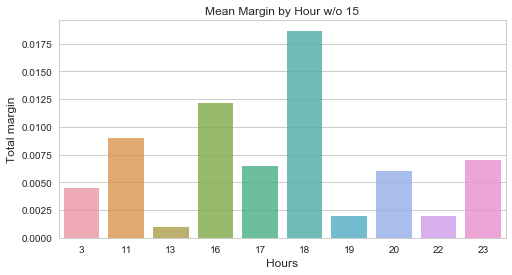

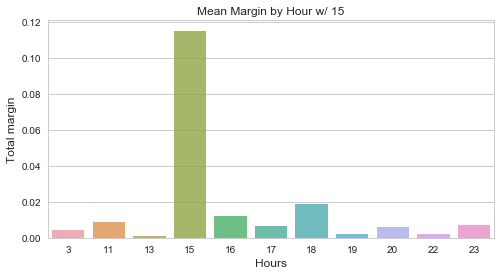

In [12]:
plt.figure(figsize=(8,4))
sns.barplot(list(map(lambda x: x[0], data)), list(map(lambda x: x[1], data)), alpha=0.8)
plt.ylabel('Total margin', fontsize=12)
plt.xlabel('Hours', fontsize=12)
plt.title('Mean Margin by Hour w/o 15')

plt.figure(figsize=(8,4))
sns.barplot(list(map(lambda x: x[0], data15)), list(map(lambda x: x[1], data15)), alpha=0.8)
plt.ylabel('Total margin', fontsize=12)
plt.xlabel('Hours', fontsize=12)
plt.title('Mean Margin by Hour w/ 15')
plt.show()

In [13]:
data = []
data15 = []
for hour in hours:
    data15.append((hour, df1[df1['Hour'] == hour]['MarginPercent'].mean()))
    if hour == 15:
        continue
    data.append((hour, df1[df1['Hour'] == hour]['MarginPercent'].mean()))

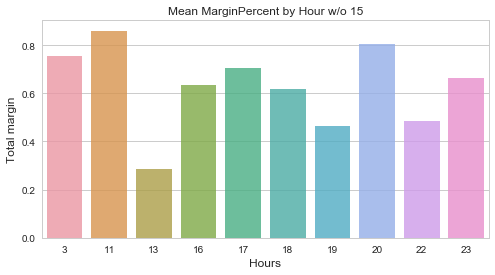

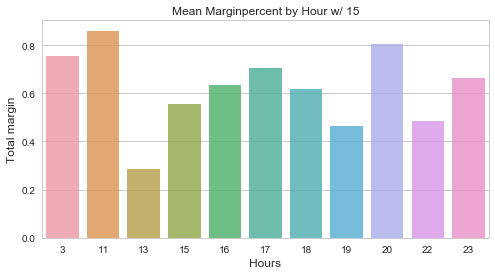

In [14]:
plt.figure(figsize=(8,4))
sns.barplot(list(map(lambda x: x[0], data)), list(map(lambda x: x[1], data)), alpha=0.8)
plt.ylabel('Total margin', fontsize=12)
plt.xlabel('Hours', fontsize=12)
plt.title('Mean MarginPercent by Hour w/o 15')

plt.figure(figsize=(8,4))
sns.barplot(list(map(lambda x: x[0], data15)), list(map(lambda x: x[1], data15)), alpha=0.8)
plt.ylabel('Total margin', fontsize=12)
plt.xlabel('Hours', fontsize=12)
plt.title('Mean Marginpercent by Hour w/ 15')
plt.show()

In [17]:
df['Domain'].value_counts().to_dict()

{'drudgereport.com': 20,
 'yummly.com': 11,
 'zillow.com': 11,
 'wimp.com': 10,
 'breitbart.com': 10,
 'buffalonews.com': 8,
 'mentalflare.com': 8,
 'm.mlb.com': 8,
 'guiltyfix.com': 8,
 'thefiscaltimes.com': 7,
 'chicago.suntimes.com': 7,
 'theblaze.com': 6,
 'tennisforum.com': 6,
 'webmaila.netzero.net': 6,
 'v.youku.com': 6,
 'pch.com': 6,
 'wrestlingforum.com': 6,
 'onthisday.com': 6,
 'screenrant.com': 6,
 'listas.20minutos.es': 6,
 'slate.com': 6,
 'virginiatech.sportswar.com': 6,
 'cmsmini.weatherbug.com': 6,
 'previously.tv': 5,
 'translationnations.com': 5,
 'legacy.com': 5,
 'videos.real.com': 5,
 'sweepsadvantage.com': 5,
 'webmailb.netzero.net': 5,
 'webmailab.netzero.net': 5,
 'talkingpointsmemo.com': 5,
 'webmailbb.netzero.net': 5,
 'thesaurus.com': 5,
 'timeinc.com': 5,
 'nationalreview.com': 5,
 'opposingviews.com': 4,
 'ads.proboards.com': 4,
 'video.10best.com': 4,
 'mariowiki.com': 4,
 'gradesaver.com': 4,
 'dailycaller.com': 4,
 'nationalenquirer.com': 4,
 'funnyord

### Price dependency for drudgereport.com (as exanple)

In [469]:
temp_df = df[df['Domain'] == 'drudgereport.com']
temp_df['Date1'] = pd.to_datetime(temp_df['Date'])
temp_df = temp_df.drop(labels=['PlacementId'], axis=1)
temp_df = temp_df[['Date', 'Date1', 'BuyCpm']]

C:\Users\dmytro.sakovych\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [470]:
test.head()

,Date,BuyCpm,SellCpm,ApbCpm,Placements,Impressions,Margin
0,2016-07-28 16:00:00,1.13733333333,3.771,0.001,12,8,0.015
1,2016-07-28 17:00:00,1.036,3.771,0.001,2,2,0.005
2,2016-07-28 18:00:00,1.13733333333,3.789,0.001,6,0,-0.006
3,2016-07-28 20:00:00,1.06,3.816,0.001,1,0,-0.001
4,2016-07-28 22:00:00,1.106,3.807,0.001,3,2,0.004


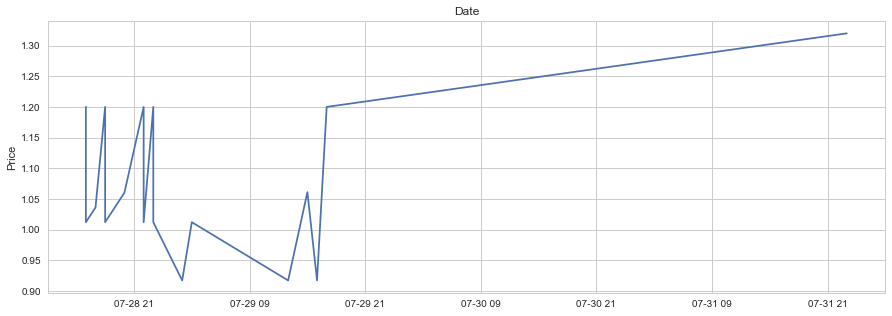

In [471]:
plt.figure(figsize=(15,5))
plt.plot(temp_df['Date1'], temp_df['BuyCpm'])
plt.ylabel('Price')
plt.title('Date');

In [472]:
temp_df = df[df['Domain'] == 'drudgereport.com']
temp_df = temp_df.drop(labels=['Hour', 'ExternalId', 'PlacementId', 'MarginPercent'], axis=1)
temp_df.head()

,Date,Domain,Placements,Impressions,FillRate,BuyCpm,SellCpm,ApbCpm,Margin
2,2016-07-31 23:00:00,drudgereport.com,1,0,0.0,1.320,3.366,0.001,-0.001
11,2016-07-29 17:00:00,drudgereport.com,1,1,1.0,1.200,3.879,0.001,0.002
14,2016-07-29 16:00:00,drudgereport.com,1,0,0.0,0.917,3.717,0.001,-0.001
15,2016-07-29 15:00:00,drudgereport.com,2,1,0.5,1.061,3.717,0.886,0.001
20,2016-07-29 13:00:00,drudgereport.com,1,0,0.0,0.917,3.717,0.883,-0.001


In [489]:
class DataFrameReducer:
    def __init__(self, df, index_label):
        self.df = df
        self.index_label = index_label
        self.__columns = [index_label]
        self.__attempt_flag = False
        self.result = None
        
    def drop_columns(self, labels, axis=1):
        self.df = self.df.drop(labels=labels, axis=axis)
    
    def reduce_by_func(self, label, func=sum):
        """ Set func (i.e. sum or np.mean)
        """
        self.__columns.append(label)
        
        lst = [(self.df[i:i+1][self.index_label].values[0], self.df[i:i+1][label].values[0]) for i in range(len(self.df))]
        lst = np.array([(k, func(list(e for _, e in list(v)))) for k, v in itertools.groupby(sorted(lst), key=lambda x : x[0])])
        if self.__attempt_flag:
            lst = np.delete(lst, np.s_[0:1], axis=1)
            self.result = np.append(self.result, lst, axis=1)
        else:
            self.__attempt_flag = True
            self.result = lst
        return pd.DataFrame(self.result, columns=self.__columns)
    
    def to_df(self):
        return pd.DataFrame(self.result, columns=self.__columns)

In [490]:
test = DataFrameReducer(temp_df, 'Date')

In [491]:
test.reduce_by_func('BuyCpm', np.mean)
test.reduce_by_func('SellCpm', np.mean)
test.reduce_by_func('ApbCpm', np.mean)
test.reduce_by_func('Placements', sum)
test.reduce_by_func('Impressions', sum)
test.reduce_by_func('Margin', sum);

In [492]:
test = test.to_df()
test['Date'] = pd.to_datetime(test['Date'])
test['BuyCpm'] = test['BuyCpm'].apply(float)
#test['Date1'] = pd.to_datetime(test['Date'])
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 7 columns):
Date           13 non-null datetime64[ns]
BuyCpm         13 non-null float64
SellCpm        13 non-null object
ApbCpm         13 non-null object
Placements     13 non-null object
Impressions    13 non-null object
Margin         13 non-null object
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 808.0+ bytes


In [484]:
test['Hour'] = test['Date'].apply(lambda x: x.hour)

,Date,BuyCpm,SellCpm,ApbCpm,Placements,Impressions,Margin,Hour
0,2016-07-28 16:00:00,1.137333,3.771,0.001,12,8,0.015,16
1,2016-07-28 17:00:00,1.036000,3.771,0.001,2,2,0.005,17
2,2016-07-28 18:00:00,1.137333,3.789,0.001,6,0,-0.006,18
3,2016-07-28 20:00:00,1.060000,3.816,0.001,1,0,-0.001,20
4,2016-07-28 22:00:00,1.106000,3.807,0.001,3,2,0.004,22
5,2016-07-28 23:00:00,1.137333,3.807,0.001,7,8,0.021,23
6,2016-07-29 02:00:00,0.917000,3.771,0.75,1,0,-0.001,2
7,2016-07-29 03:00:00,1.012000,4.122,0.713,1,1,0.003,3
8,2016-07-29 13:00:00,0.917000,3.717,0.883,1,0,-0.001,13
9,2016-07-29 15:00:00,1.061000,3.717,0.886,2,1,0.001,15


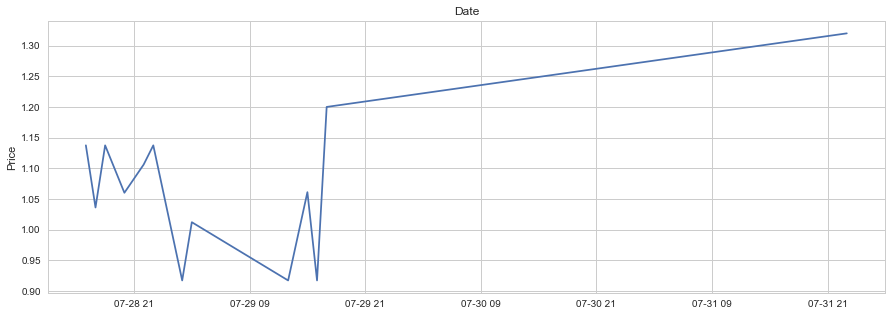

In [493]:
plt.figure(figsize=(15,5))
plt.plot(test['Date'], test['BuyCpm'])
plt.ylabel('Price')
plt.title('Date');

In [499]:
test['Label'] = test['Margin'].apply(lambda x: 1 if float(x) > 0 else 0)

In [500]:
test

,Date,BuyCpm,SellCpm,ApbCpm,Placements,Impressions,Margin,Label
0,2016-07-28 16:00:00,1.137333,3.771,0.001,12,8,0.015,1
1,2016-07-28 17:00:00,1.036000,3.771,0.001,2,2,0.005,1
2,2016-07-28 18:00:00,1.137333,3.789,0.001,6,0,-0.006,0
3,2016-07-28 20:00:00,1.060000,3.816,0.001,1,0,-0.001,0
4,2016-07-28 22:00:00,1.106000,3.807,0.001,3,2,0.004,1
5,2016-07-28 23:00:00,1.137333,3.807,0.001,7,8,0.021,1
6,2016-07-29 02:00:00,0.917000,3.771,0.75,1,0,-0.001,0
7,2016-07-29 03:00:00,1.012000,4.122,0.713,1,1,0.003,1
8,2016-07-29 13:00:00,0.917000,3.717,0.883,1,0,-0.001,0
9,2016-07-29 15:00:00,1.061000,3.717,0.886,2,1,0.001,1


In [530]:
model_buy = pf.ARIMA(data=test, ar=4, ma=4, integ=0, target='BuyCpm')

In [531]:
x = model_buy.fit("MLE")
x.summary()

Normal ARIMA(4,0,4)                                                                                       
======================================================= ==================================================
Dependent Variable: BuyCpm                              Method: MLE                                       
Start Date: 4                                           Log Likelihood: 16.0839                           
End Date: 12                                            AIC: -12.1679                                     
Number of observations: 9                               BIC: -10.1956                                     
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 3.4966     1.4621     2.3915   0.0168   (0.6308 | 6.3624)        
AR(1)                                

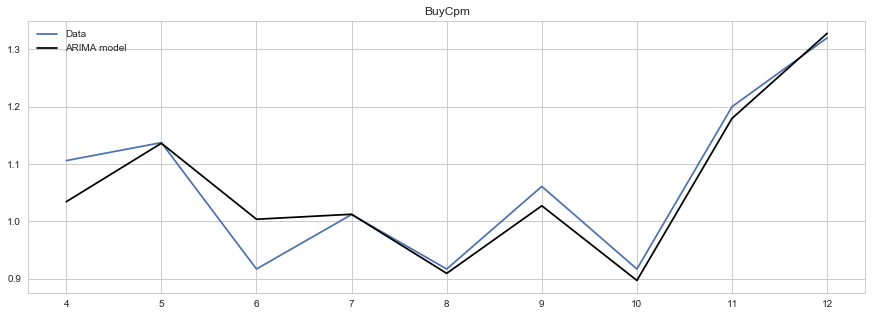

In [532]:
model_buy.plot_fit(figsize=(15,5))

In [533]:
model_buy.predict(h=1)

,BuyCpm
13,2.471961


In [534]:
model_sell = pf.ARIMA(data=test, ar=4, ma=4, integ=0, target='SellCpm')

In [535]:
x = model_sell.fit("MLE")
x.summary()

Normal ARIMA(4,0,4)                                                                                       
======================================================= ==================================================
Dependent Variable: SellCpm                             Method: MLE                                       
Start Date: 4                                           Log Likelihood: 11.4053                           
End Date: 12                                            AIC: -2.8107                                      
Number of observations: 9                               BIC: -0.8384                                      
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 3.0134     3.2236     0.9348   0.3499   (-3.3049 | 9.3317)       
AR(1)                                

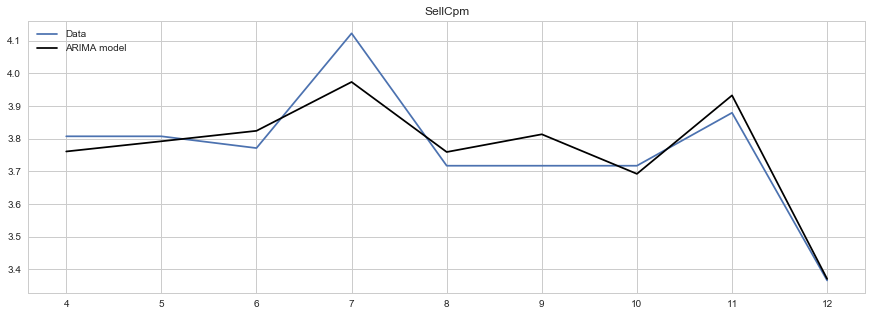

In [536]:
model_sell.plot_fit(figsize=(15,5))

In [537]:
model_sell.predict(h=1)

,SellCpm
13,5.410702


In [538]:
X_train, X_test, y_train, y_test = train_test_split(test.drop(labels=['Label', 'Date'], axis=1), 
                                                    test['Label'], 
                                                    test_size=0.25,
                                                    random_state=256)

In [539]:
clf = RandomForestClassifier(max_depth=2, random_state=0)

In [540]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [543]:
train_predictions = clf.predict(X_test)

In [545]:
acc = accuracy_score(y_test, train_predictions)
print("Accuracy: {:.4%} \n".format(acc))

Accuracy: 100.0000% 

